In [37]:
import pandas as pd
import torch
import numpy as np
from utils import process_df
import os
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from statistics import mode
from collections import defaultdict
import pickle

In [2]:
def get_data():
    '''
    Get second innings data for training and test
    '''
    data_dir = "ipl_csv2"
    file_list = os.listdir(data_dir)
    file_list = [x for x in file_list if 'info' not in x and 'csv' in x]
    file_list.remove('all_matches.csv')

    df_list = []
    for matches in tqdm(file_list):
        # print(matches)
        df_list.append(process_df(pd.read_csv(os.path.join(data_dir,matches))))
    
    seasons = list(set([df.season.unique()[0] for df in df_list]))

    train = []
    test = []
    for df in df_list:
        if df.season.unique()[0] > 2021:
            test.append(df)
        else:
            train.append(df)
    
    train_data = pd.concat(train)
    train_data= train_data.query("innings == 2")
    test_data = pd.concat(test)
    test_data = test_data.query("innings == 2")

    # train_X,test_X = train_data[train_cols],test_data[train_cols]
    # train_Y,test_Y = train_data[target_cols],test_data[target_cols]

    return train_data,test_data

- Get time series of batsmen, cluster their innings to labels, assign their label based on most frequent label;
- On the test set, get the innings of each batsman and aggregate their runs over balls faced
- similarly take the xR for the above balls
- compare the cumulative effects for all clusters
- optimal innings construction template

In [3]:
train_data, test_data = get_data()

  0%|          | 0/1024 [00:00<?, ?it/s]

In [4]:
train_cols = [ 'match_id','ball','wickets_left','striker','runs_left']
# state_train_cols = ['ball','wickets_left','runs_left']
target_cols = ['runs_off_bat']

In [5]:
time_series = []
player_labels = []

for m in train_data.match_id.unique():
    for player in train_data.query('match_id == @m')['striker'].unique():
        q_df = train_data.query("match_id == @m and striker == @player")
        time_series.append(q_df['runs_off_bat'].values)
        player_labels.append(player)
        # break

In [6]:
time_series[-1],player_labels[-1]

(array([0]), 'SK Trivedi')

In [7]:
train_data.query("match_id == @m and striker == @player")

,match_id,season,venue,innings,ball,striker,non_striker,bowler,runs_off_bat,extras,...,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,wicket,wickets_left,total_runs,runs_left
244,598065,2013,"Rajiv Gandhi International Stadium, Uppal",2,19.6,SK Trivedi,PV Tambe,DW Steyn,0,0,...,0.0,0.0,0,NaN,NaN,NaN,0,1,0,24.0


In [8]:
innings_cut_off = 10

In [9]:
formatted_dataset = to_time_series_dataset([innings for innings in time_series if len(innings)>10])

In [10]:
# len(list(filter(lambda x:len(x)>5,time_series)))

In [11]:
formatted_dataset.shape

(3336, 70, 1)

In [12]:
sum_of_distances = []
km_model_zoo = {}
for cluster_size in tqdm(range(2,8)):

    km = TimeSeriesKMeans(n_clusters=cluster_size,n_init=10,metric='dtw',n_jobs=-1,random_state=42)
    km.fit(formatted_dataset)
    km_model_zoo[cluster_size] = km
    sum_of_distances.append(km.inertia_)

  0%|          | 0/6 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Inertia vs Number of clusters')

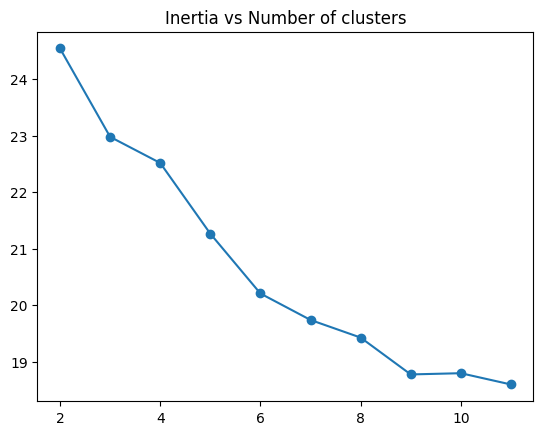

In [80]:
plt.plot(range(2,12),sum_of_distances,marker = 'o')
plt.title("Inertia vs Number of clusters")

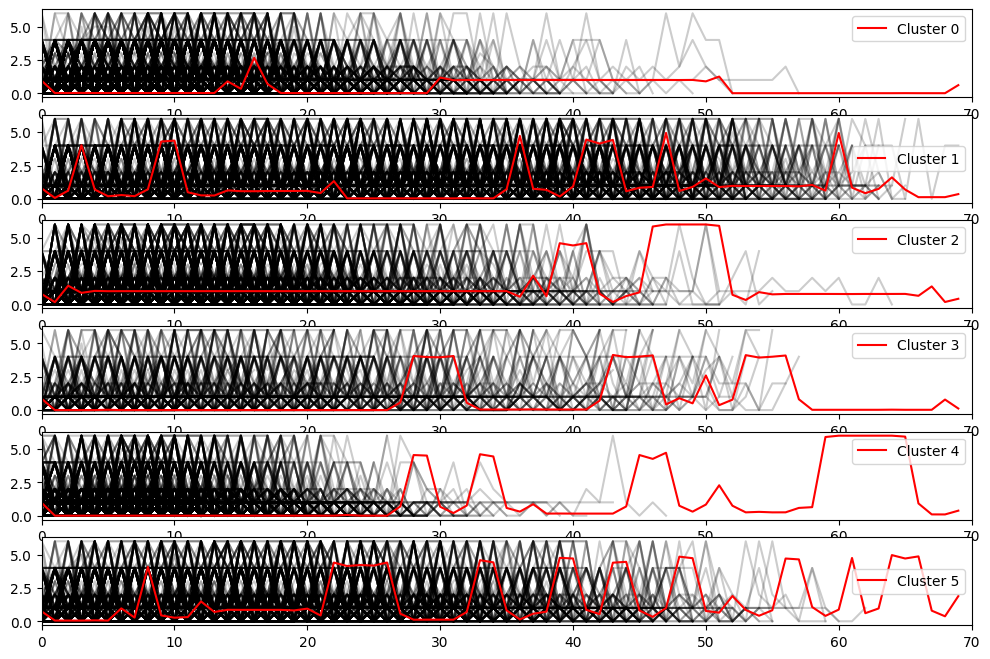

In [81]:
optimal_cluster_size = 6
y_pred = km_model_zoo[optimal_cluster_size].predict(formatted_dataset)

fig,ax = plt.subplots(optimal_cluster_size, 1,figsize = (12,8))

for yi in range(optimal_cluster_size):
    # plt.
    for xx in formatted_dataset[y_pred == yi]:
        ax[yi].plot(xx.ravel(), "k-", alpha=.2)
    ax[yi].plot(km.cluster_centers_[yi].ravel(), "r-",label = f"Cluster {yi}")
    ax[yi].set_xlim(0, formatted_dataset.shape[1])
    # plt.ylim(-4, 4)
    # ax[yi].text(0.9, 0.85,'Cluster %d' % (yi + 1),
    #          transform=plt.gca().transAxes)
    # if yi == 0:
    #     # plt.title("DBA $k$-means")
    ax[yi].legend()


In [82]:
formatted_player_labels = []
for idx,innings in enumerate(time_series): #can probably do this initially itself to avoid extra loop
    if len(innings)>innings_cut_off:
        formatted_player_labels.append(player_labels[idx])

In [83]:
#get optimal clusters
player_dict = defaultdict(list)

for idx,player in enumerate(formatted_player_labels):
    player_dict[player].append(km_model_zoo[optimal_cluster_size].labels_[idx])    

In [84]:
player_clusters = {}
for player in player_dict.keys():
    player_clusters[player] = mode(player_dict[player])

In [89]:
pd.DataFrame(player_clusters.items(),columns=['Player','Cluster']).query("Cluster == 5")

,Player,Cluster
4,DA Warner,5
22,S Dhawan,5
29,AM Rahane,5
44,RD Gaikwad,5
48,BB McCullum,5
92,A Ashish Reddy,5
109,ML Hayden,5
113,LMP Simmons,5
122,RR Pant,5
180,N Pooran,5


In [92]:
pd.DataFrame(player_clusters.items(),columns=['Player','Cluster']).to_csv("Player_Cluster.csv",index=False)

In [48]:
# filename = "clustering_model_{}.sav"

for cluster_size in range(2,12):

    pickle.dump(km_model_zoo[cluster_size],open(f"clustering_model_{cluster_size}.sav",'wb'))
    

In [47]:
for cluster_size in tqdm(range(10,12)):
    km = TimeSeriesKMeans(n_clusters=cluster_size,n_init=10,metric='dtw',n_jobs=-1,random_state=42)
    km.fit(formatted_dataset)
    km_model_zoo[cluster_size] = km
    sum_of_distances.append(km.inertia_)

  0%|          | 0/2 [00:00<?, ?it/s]

In [45]:
pickle.load(open("clustering_model_9.sav", 'rb')).cluster_centers_

array([[[9.04687500e-01],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.23325062e-02],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [2.48138958e-03],
        [1.50205761e+00],
        [7.32334047e-01],
        [1.00248139e+00],
        [9.82630273e-01],
        [9.85111663e-01],
        [9.85111663e-01],
        [9.85111663e-01],
        [9.85111663e-01],
        [9.87593052e-01],
        [9.65432099e-01],
        [1.06490385e+00],
        [1.24069479e-01],
        [1.24069479e-01],
        [1.24069479e-01],
        [1.45679012e-01],
        [1.24069479e-01],
        [1.24069479e-01],
        [1.24069479e-01],
        [1.24069479e-01],
        [1.2